<a href="https://colab.research.google.com/github/mzignis/hands_on_machine_learning/blob/master/artificial_neural_networks/mnist_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as plt_patches
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
mnist = fetch_openml('mnist_784', version=1)

In [0]:
X = mnist.data
y = mnist.target.astype(np.int)

In [0]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full)

In [5]:
input_shape = X_train.shape[1]
X_train.shape, y_train.shape

((39375, 784), (39375,))

In [0]:
def create_model(params: dict):
    model = keras.models.Sequential()

    # -------- input layer --------
    model.add(keras.Input(shape=X_train.shape[1:]))

    # -------- deep layers --------
    layers_number = params.get('deep_layers_no', 1)
    neurons_number = params.get('neurons_number', 200)
    for layer_no in range(layers_number):
        model.add(keras.layers.Dense(neurons_number, activation='relu'))

    # -------- output layer --------
    model.add(keras.layers.Dense(10, activation='softmax'))

    learning_rate = params.get('learning_rate', 1e-3)
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=keras.optimizers.SGD(lr=learning_rate), 
                  metrics=["accuracy"])
    
    return model

In [0]:
def fit_model(model, X_train, y_train, params: dict):
    history = model.fit(X_train, y_train, 
                        batch_size=params.get('batch_size', 32),
                        epochs=params.get('epochs', 5),
                        verbose=params.get('verbose', 1),
                        validation_data=params.get('validation_data', (X_train, y_train)),
                        callbacks=params.get('callbacks', []))
    return history

In [0]:
def fit_and_evaluate(X, y, model_params: dict = None, fit_params: dict = None):
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full)

    model_params = dict() if model_params is None else model_params
    fit_params = dict() if fit_params is None else fit_params
    fit_params.update({'validation_data': (X_val, y_val)})

    print(' creating model '.center(32, '-'))
    model = create_model(model_params)
    model.summary()
    print('\n\n')

    print(' training model '.center(32, '-'))
    history = fit_model(model, X_train, y_train, fit_params)
    print('\n\n')

    print(' evaluating model'.center(32, '-'))
    score = model.evaluate(X_test, y_test)
    print(score)

    return model, history

-------- creating model --------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2010      
Total params: 239,410
Trainable params: 239,410
Non-trainable params: 0
_________________________________________________________________



-------- training model --------
Epoch 1/150
1231/1231 [==============================] - 4s 3ms/step - loss: 3.3617 - accuracy: 0.7863 - val_loss: 1.6428 - val_accuracy: 0.8503
Epoch 2/150
1231/1231 [===========

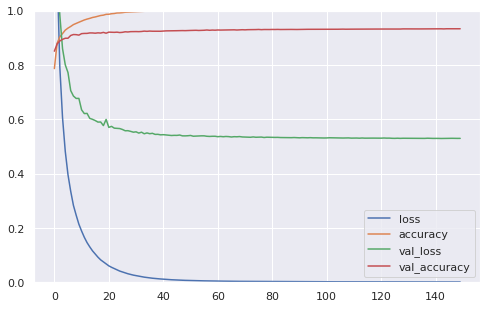

In [9]:
model, history = fit_and_evaluate(X, y, 
                                  model_params={'deep_layers_no': 3, 
                                                'neurons_number': 200,
                                                'learning_rate': 1e-4},
                                  fit_params={'batch_size': 32, 
                                              'epochs': 150})

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

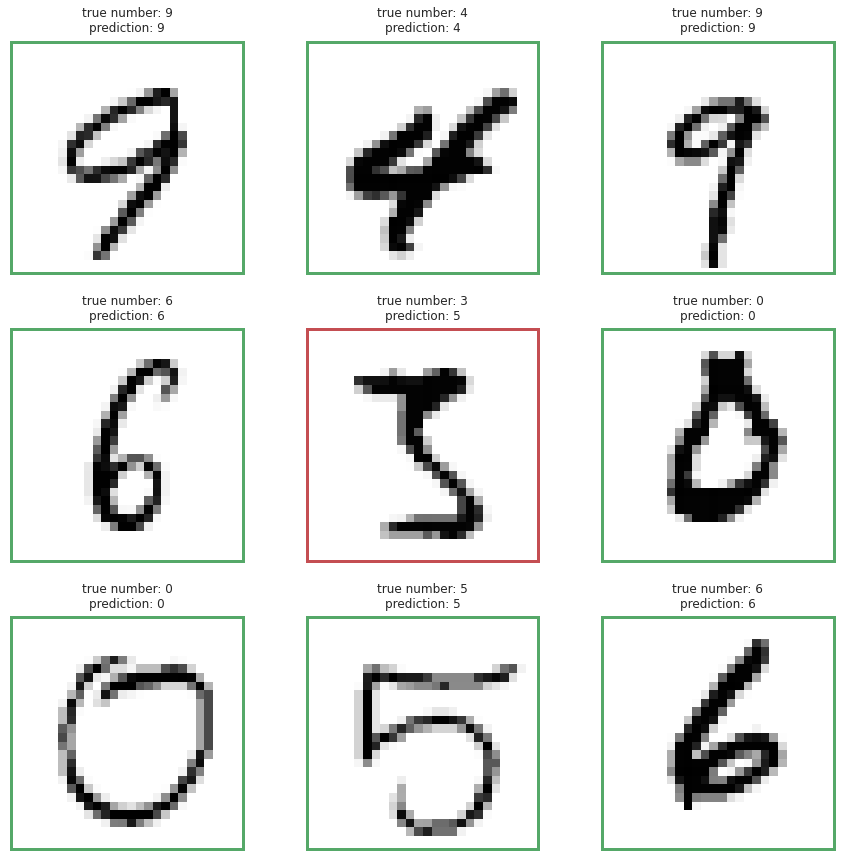

In [14]:
idx = np.random.randint(X_test.shape[0], size=9)
X_new, y_new = X_test[idx, :], y_test[idx]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

idx = -1
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        idx += 1

        X_loc = X_new[idx]
        y_pred = model.predict_classes(X_loc.reshape(1, -1))[0]
        square_color = 'g' if y_pred == y_new[idx] else 'r'
        frame = plt_patches.Rectangle((0, 0), 27, 27, edgecolor=square_color, facecolor='none', lw=3)
        ax.imshow(X_loc.reshape(28, 28), cmap='Greys')
        ax.add_patch(frame)
        ax.set_title(f'true number: {y_new[idx]}\nprediction: {y_pred}')
        ax.axis('off')